In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

import xgboost as xgb

from scipy import sparse
from IPython.display import Image
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

sns.set(style="ticks", color_codes=True)
%matplotlib inline

import os
import json

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from datetime import datetime
import dateutil

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [198]:
full=pd.read_csv('dataset.csv', sep=',', na_values='NaN')

# Drop corrupted images
#full = full[full['urlImage'] != 'https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18161692_170571873469417_6901717925879611392_n.jpg']
#full = full[full['urlImage'] != 'https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/18251971_1131644876964262_6190143287764975616_n.jpg']

y=full["numberLikes"]

toDrop = ['username', 'urlProfile', 'urlImgProfile', 'filename', 'url', 'urlImage', 'isVideo']
processed = full.drop(toDrop,axis=1)

nonCat = ['descriptionProfile', 'description', 'tags', 'mentions', 'localization']
processed = processed.drop(nonCat, axis=1)

In [199]:
full.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes
count,16539.000000,1.653900e+04,1.653900e+04,1.653900e+04
mean,2315.732451,2.590563e+03,9.978294e+05,2.441426e+04
std,2655.384118,5.909066e+04,1.934401e+06,6.422060e+04
min,15.000000,0.000000e+00,1.249650e+05,0.000000e+00
25%,787.000000,1.910000e+02,1.980390e+05,3.232500e+03
50%,1481.000000,3.960000e+02,3.938430e+05,7.351000e+03
75%,2932.000000,6.450000e+02,9.353100e+05,1.835700e+04
max,27671.000000,1.838511e+06,2.213073e+07,1.115123e+06


# NLP

In [200]:
nlp = pd.read_csv('NLP_feature.csv', sep=',', na_values='NaN')

# NN Joseph

In [201]:
nn_train = pd.read_csv('train_ll.csv', sep=',', na_values='NaN')
nn_train.columns = ['0_', '1_', '2_', '3_', '4_', '5_', '6_', '7_']
nn_test = pd.read_csv('test_ll.csv', sep=',', na_values='NaN')
nn_test.columns = ['0_', '1_', '2_', '3_', '4_', '5_', '6_', '7_']

# Filtering

### AliasNum

In [202]:
le = preprocessing.LabelEncoder()
le.fit(processed["alias"])
list(le.classes_)
alias_num=le.transform(processed["alias"])
#list(le.inverse_transform(alias_num))
processed["aliasNum"]=alias_num

### Actual filtering

In [203]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"]+1,axis=0)):
    numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(processed[processed["aliasNum"]==i]["numberLikes"])/len(processed[processed["aliasNum"]==i]))
    processed.loc[processed["aliasNum"]==i, 'ratio']=avgLikes[i]
    #if (avgLikes[i]<20000000 and processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000000):
    selection=np.append(selection, i)

In [204]:
processed.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes,aliasNum,ratio
count,16539.000000,1.653900e+04,1.653900e+04,1.653900e+04,16539.000000,16539.000000
mean,2315.732451,2.590563e+03,9.978294e+05,2.441426e+04,485.943527,24414.257875
std,2655.384118,5.909066e+04,1.934401e+06,6.422060e+04,280.859278,61676.810047
min,15.000000,0.000000e+00,1.249650e+05,0.000000e+00,0.000000,110.866667
25%,787.000000,1.910000e+02,1.980390e+05,3.232500e+03,243.000000,3594.764706
50%,1481.000000,3.960000e+02,3.938430e+05,7.351000e+03,486.000000,7678.647059
75%,2932.000000,6.450000e+02,9.353100e+05,1.835700e+04,729.000000,18718.941176
max,27671.000000,1.838511e+06,2.213073e+07,1.115123e+06,972.000000,875806.411765


# Concatenate nlp

In [205]:
processed = pd.concat([processed, nlp], axis=1)

# Filtered version

In [206]:
filtered=processed[processed['aliasNum'].isin(selection)]
filtered.describe()

,numberPosts,numberFollowing,numberFollowers,numberLikes,aliasNum,ratio,able,account,actually,ad,...,27,28,29,30,31,32,33,34,35,36
count,16539.000000,1.653900e+04,1.653900e+04,1.653900e+04,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000,...,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000,16539.000000
mean,2315.732451,2.590563e+03,9.978294e+05,2.441426e+04,485.943527,24414.257875,0.006288,0.006107,0.005925,0.014330,...,0.014330,0.016990,0.016083,0.013786,0.027994,0.013241,0.014934,0.029687,0.031622,0.012274
std,2655.384118,5.909066e+04,1.934401e+06,6.422060e+04,280.859278,61676.810047,0.082787,0.083889,0.079840,0.121367,...,0.140315,0.201312,0.171729,0.134877,0.217734,0.396814,0.125701,0.242236,0.244230,0.127420
min,15.000000,0.000000e+00,1.249650e+05,0.000000e+00,0.000000,110.866667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,787.000000,1.910000e+02,1.980390e+05,3.232500e+03,243.000000,3594.764706,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1481.000000,3.960000e+02,3.938430e+05,7.351000e+03,486.000000,7678.647059,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2932.000000,6.450000e+02,9.353100e+05,1.835700e+04,729.000000,18718.941176,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,27671.000000,1.838511e+06,2.213073e+07,1.115123e+06,972.000000,875806.411765,2.000000,2.000000,2.000000,3.000000,...,4.000000,9.000000,9.000000,6.000000,7.000000,18.000000,3.000000,3.000000,2.000000,5.000000


# Feature extraction

In [207]:
modified = filtered.drop(["alias"],axis=1)
modified = modified.reset_index(drop=True)

### Website

In [208]:
modified['you']=modified['website'].str.contains("youtube|youtu", na=False).astype(int)
modified['music']=modified['website'].str.contains("soundcloud|spoti", na=False).astype(int)
modified['tumblr']=modified['website'].str.contains("tumblr", na=False).astype(int)
modified['facebook']=modified['website'].str.contains("facebook", na=False).astype(int)
modified['blog']=modified['website'].str.contains("blog|wordpress", na=False).astype(int)
modified['twitter']=modified['website'].str.contains("twitter", na=False).astype(int)
modified['other']=modified['website'].str.contains(".", na=False).astype(int)

modified = modified.drop(['website'], axis=1)

### Multiple image to int

In [209]:
modified['multipleImage']=modified['multipleImage'].astype(int)

### Convert days to days of week

In [210]:
copy=modified["date"].copy()
for i in range(0, len(modified)):
    copy[i] = datetime.weekday((dateutil.parser.parse(modified["date"][i])))
modified["date"]=copy.astype(np.int64)

modified['mon']=(modified['date']==0).astype(int)
modified['tue']=(modified['date']==1).astype(int)
modified['wed']=(modified['date']==2).astype(int)
modified['thu']=(modified['date']==3).astype(int)
modified['fri']=(modified['date']==4).astype(int)
modified['sat']=(modified['date']==5).astype(int)
modified['sun']=(modified['date']==6).astype(int)

modified = modified.drop(['date'], axis=1)

In [211]:
modified

,numberPosts,numberFollowing,numberFollowers,multipleImage,numberLikes,aliasNum,ratio,able,account,actually,...,tumblr,facebook,twitter,other,mon,tue,wed,thu,fri,sat
0,988,233,720979,0,10047,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,988,233,720979,0,16781,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,988,233,720979,0,11227,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,988,233,720979,0,21539,0,23400.941176,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,988,233,720979,0,21054,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,0,0,1
5,988,233,720979,0,12375,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,988,233,720979,0,15335,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,0,1,0
7,988,233,720979,0,29161,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8,988,233,720979,0,10267,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9,988,233,720979,0,29776,0,23400.941176,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [212]:
deleted=modified[modified["aliasNum"].astype(int)==0][0:2]
test=modified[modified["aliasNum"].astype(int)==0][3:6]
train=modified[modified["aliasNum"].astype(int)==0][6:len(modified[modified["aliasNum"].astype(int)==0])]

for i in range(1,np.max(modified["aliasNum"].astype(int),axis=0)):
#for i in range(0,10):
    deleted = pd.concat([deleted, modified[modified["aliasNum"]==i][0:2]], axis=0)
    test = pd.concat([test, modified[modified["aliasNum"]==i][3:6]], axis=0)
    train = pd.concat([train, modified[modified["aliasNum"]==i][6:len(modified[modified["aliasNum"]==i])]], axis=0)

In [213]:
X_train = train
X_test = test

In [147]:
X_train = train.drop(['numberLikes'],axis=1)
#X_train = X_train.drop(['ratio'],axis=1)
y_train = train['numberLikes']
X_test = test.drop(['numberLikes'],axis=1)
#X_test = X_test.drop(['ratio'],axis=1)
y_test = test['numberLikes']

### Add NN features

In [214]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train = pd.concat([X_train, nn_train], axis=1)
X_test = pd.concat([X_test, nn_test], axis=1)

In [62]:
modified.shape

(16520, 556)

In [215]:
X_train

,numberPosts,numberFollowing,numberFollowers,multipleImage,numberLikes,aliasNum,ratio,able,account,actually,...,fri,sat,0_,1_,2_,3_,4_,5_,6_,7_
0,988,233,720979,0,15335,0,23400.941176,0,0,0,...,1,0,0.0,32543.703125,44026.816406,47244.664062,42217.406250,39983.046875,48795.449219,40017.890625
1,988,233,720979,0,29161,0,23400.941176,0,0,0,...,1,0,0.0,41052.175781,55537.695312,59596.625000,53255.234375,50436.632812,61552.941406,50480.511719
2,988,233,720979,0,10267,0,23400.941176,0,0,0,...,1,0,0.0,61528.851562,83239.804688,89323.570312,79818.765625,75594.351562,92255.835938,75660.218750
3,988,233,720979,0,29776,0,23400.941176,0,0,0,...,0,0,0.0,49510.664062,66980.898438,71876.148438,64228.156250,60828.812500,74235.664062,60881.738281
4,988,233,720979,0,27991,0,23400.941176,0,0,0,...,0,0,0.0,38410.343750,51963.660156,55761.390625,49828.082031,47190.894531,57591.921875,47231.976562
5,988,233,720979,0,35952,0,23400.941176,0,0,0,...,0,0,0.0,56370.589844,76261.437500,81834.968750,73127.265625,69256.875000,84521.351562,69317.187500
6,988,233,720979,0,15247,0,23400.941176,0,0,0,...,0,1,0.0,34209.625000,46280.601562,49663.042969,44378.585938,42029.792969,51293.378906,42066.484375
7,988,233,720979,0,19743,0,23400.941176,0,0,0,...,0,0,0.0,38348.492188,51879.957031,55671.632812,49747.761719,47114.832031,57499.113281,47155.894531
8,988,233,720979,0,49868,0,23400.941176,0,0,0,...,0,0,0.0,45007.148438,60888.187500,65338.164062,58385.816406,55295.644531,67483.062500,55343.839844
9,988,233,720979,0,51663,0,23400.941176,0,0,0,...,0,0,0.0,23800.703125,32198.681641,34552.031250,30875.476562,29241.394531,35686.230469,29266.888672


In [216]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"],axis=0)):
    print(i)
    #numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(X_train[X_train["aliasNum"]==i]["numberLikes"])/len(X_train[X_train["aliasNum"]==i]))
    X_train.loc[X_train["aliasNum"]==i, 'ratio']=avgLikes[i]
    if (avgLikes[i]<200000 and X_train[X_train["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000):
        selection=np.append(selection, i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [217]:
avgLikes = []
numFollowers = []
selection = []

for i in range(0,np.max(processed["aliasNum"],axis=0)):
    print(i)
    #numFollowers=np.append(numFollowers, processed[processed["aliasNum"]==i]['numberFollowers'].iloc[0])
    avgLikes=np.append(avgLikes, np.sum(X_test[X_test["aliasNum"]==i]["numberLikes"])/len(X_test[X_test["aliasNum"]==i]))
    X_test.loc[X_test["aliasNum"]==i, 'ratio']=avgLikes[i]
    if (avgLikes[i]<200000 and X_test[X_test["aliasNum"]==i]['numberFollowers'].iloc[0]<1000000):
        selection=np.append(selection, i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [218]:
X_train=X_train[X_train['aliasNum'].isin(selection)]
X_test=X_test[X_test['aliasNum'].isin(selection)]

y_train = X_train['numberLikes']
X_train = X_train.drop(['numberLikes'],axis=1)

y_test = X_test['numberLikes']
X_test = X_test.drop(['numberLikes'],axis=1)

In [219]:
model_xgb = xgb.XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=596)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(RMSE)

2898.81876782


In [220]:
X_train.describe()

,numberPosts,numberFollowing,numberFollowers,multipleImage,aliasNum,ratio,able,account,actually,ad,...,fri,sat,0_,1_,2_,3_,4_,5_,6_,7_
count,8204.000000,8.204000e+03,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,...,8204.000000,8204.000000,8204.0,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000,8204.000000
mean,1941.187957,3.026565e+03,362533.645904,0.025963,479.754632,8460.375061,0.006704,0.005851,0.006095,0.014627,...,0.137128,0.123476,0.0,48879.034932,66126.362853,70959.233427,63408.731744,60052.760731,73288.623744,60105.054725
std,2007.691474,6.726324e+04,227126.803505,0.159034,281.615550,9505.766332,0.084543,0.080924,0.080906,0.124057,...,0.344004,0.329003,0.0,15003.591789,20297.834858,21781.325118,19463.620486,18433.480495,22496.368975,18449.530099
min,15.000000,0.000000e+00,124965.000000,0.000000,0.000000,105.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,5209.350098,7047.171387,7562.185547,6757.602539,6399.988770,7810.350586,6405.569336
25%,722.000000,2.020000e+02,180286.000000,0.000000,239.000000,2973.272727,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,38708.724609,52367.288086,56194.555664,50215.114258,47557.437500,58039.262695,47598.861328
50%,1369.000000,4.050000e+02,283490.000000,0.000000,477.000000,5566.090909,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,48254.236328,65281.070312,70052.250000,62598.126953,59285.087891,72351.832031,59336.763672
75%,2566.000000,6.560000e+02,493550.000000,0.000000,726.000000,10775.545455,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,58583.896484,79255.718750,85048.115234,75998.464844,71976.138672,87839.990234,72038.810547
max,19590.000000,1.838511e+06,996578.000000,1.000000,971.000000,117994.545455,2.000000,2.000000,2.000000,3.000000,...,1.000000,1.000000,0.0,93391.101562,126345.148438,135579.265625,121152.601562,114740.460938,140029.968750,114840.406250


In [221]:
model_xgb.score(X_test,y_test)

0.91617132850151906

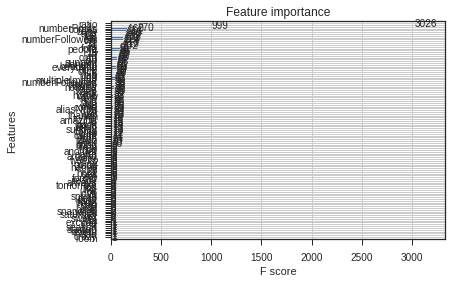

In [194]:
xgb.plot_importance(model_xgb, importance_type='weight') # weight, gain or cover

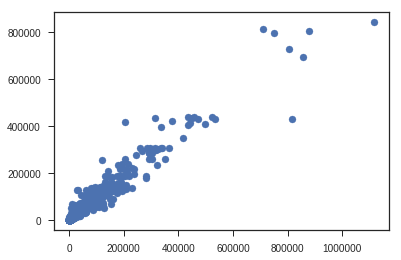

In [195]:
plt.scatter(y_test, y_pred)
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

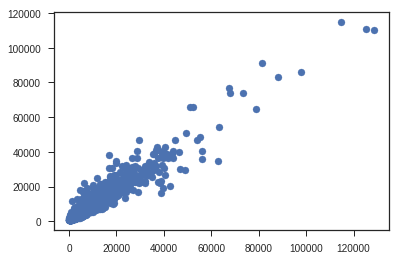

In [222]:
plt.scatter(y_test, y_pred)
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

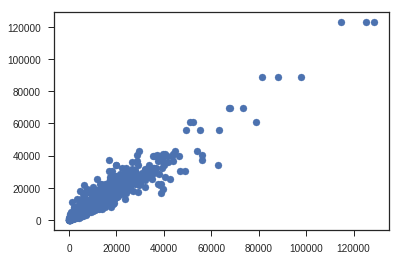

In [223]:
plt.scatter(y_test, X_test['ratio'])
#plt.xlim(0, 40000)
#plt.ylim(0, 60000)

### Test vs residuals

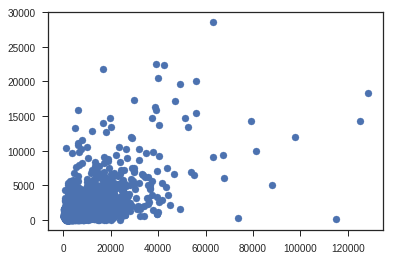

In [224]:
plt.scatter(y_test, abs(y_pred-y_test))

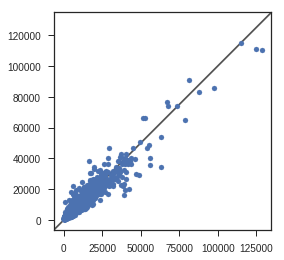

In [225]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()